1.984957561740966e-05
0.9310349406037572
1.3320085161183047e-12
58955.62586511473


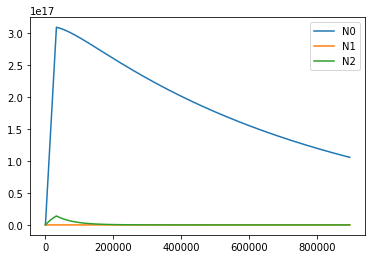

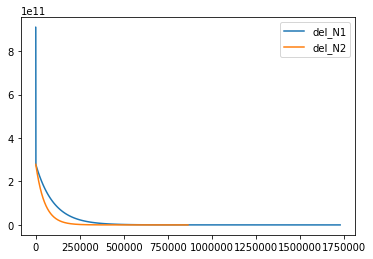

-0.06993914573299108


In [46]:
from tqdm.notebook import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import math

class Optimum_foil:
    def __init__(self):
        self.Threshhold_MIN = float(0)
        self.Threshhold_MAX = float(10E+6)
        self.reference = "../reference/"
        self.all_reaction_list = []#JENDLから読み取ったすべての核種のすべての反応の情報
        self.all_cross_section_list = []#JENDLから読み取ったすべての核種のすべての反応の断面積
        self.reaction_list = []
        self.cross_section_list = []
        self.cross_section_Nb_list = []
        self.sigma_reaction_Nb = 0
        self.ll=["(n,He3)","(n,t)","(n,2na)","(n,2p)","(n,d)","(n,2n)","(n,np)","(n,p)","(n,pa)","(n,na)","(n,n')","(n,a)"]#自分が書いた反応

        
#         self.Calc_efficiency("efficiency.txt")
#         self.Make_reaction_list_cross_section_list()

        self.Calc_activation()
        
    def Calc_efficiency(self,x):
        self.Read_tab_splited(x)
        self.Curve_fit(self.tab_splited)
        
    def Make_reaction_list_cross_section_list(self):
        self.Read_NIST("NIST.txt")
        self.Read_JENDL("jendl-ad2017_300K.tar/jendl-ad2017_300K/")
        self.Calc_fai_sigma(self.cross_section_list)
        #reaction_listにΣσφを追加
        for i in range(len(self.cross_section_list)):
            self.reaction_list[i].append(self.sigma_reaction_list[i])
#             print(self.reaction_list[i])
        #NbのΣσφを計算
        self.Calc_fai_sigma(self.cross_section_Nb_list)
        self.sigma_reaction_Nb = self.sigma_reaction_list[0]

    def numeric(self, a):
        k = ""
        if a[len(a)-2] == "+" or a[len(a)-2] == "-":
            for i in range(len(a)):
                if i == len(a)-2:
                    k = k + "E" + a[i]
                else:
                    k = k + a[i]
            return k
        if a[len(a)-3] == "+" or a[len(a)-3] == "-":
            for i in range(len(a)):
                if i == len(a)-3:
                    k = k + "E" + a[i]
                else:
                    k = k + a[i]
            return k
        
    def Read_tab_splited(self, x):
        self.tab_splited = []
        f = open(self.reference + x)
        line = f.readline()
        while line:
            self.tab_splited.append(line.rstrip().split("\t"))
            line = f.readline()
        f.close
        
    def Read_n_splited(self ,x):
        self.n_splited = []
        f = open(self.reference + x)
        data1 = f.read()
        f.close()
        lines1 = data1.split("\n") 
        for line in lines1:
            self.n_splited.append(line+"  ")
            
    def Read_NIST(self, x):
        self.nist_list = []
        self.natural_element_nist_list = []#自然界に存在する核種の元素記号
        self.natural_comp_list = []#自然界に存在する核種の存在比
        self.natural_ramass_list = []#自然界に存在する核種の相対原子質量
        self.natural_massnum_list = []#自然界に存在する核種の原子番号
        self.natural_saw_list = []#自然界に存在する核種の平均質量数
        self.element_nist_list = []#すべての元素記号
        self.massnum_list = []#すべての原子番号
        self.Read_n_splited(x)
        self.nist_list = self.n_splited

        for i in range(math.floor(len(self.nist_list)/8)):
            if len(self.nist_list[8*i+4]) != 25:#Isotopic Compositionのデータがあるとき（存在比が有意）
                if self.nist_list[8*i+2][15] == " ":#質量数が１桁の時
                    self.natural_element_nist_list.append(self.nist_list[8*i+1][16]+self.nist_list[8*i+1][17]+"-"+self.nist_list[8*i+2][14].rjust(3))
                elif self.nist_list[8*i+2][16] == " ":#質量数が2桁の時
                    self.natural_element_nist_list.append(self.nist_list[8*i+1][16]+self.nist_list[8*i+1][17]+"-"+(self.nist_list[8*i+2][14]+self.nist_list[8*i+2][15]).rjust(3))
                else:#質量数が３桁の時
                    self.natural_element_nist_list.append(self.nist_list[8*i+1][16]+self.nist_list[8*i+1][17]+"-"+self.nist_list[8*i+2][14]+self.nist_list[8*i+2][15]+self.nist_list[8*i+2][16])

                #同位体存在比を抽出--------------------
                s=self.nist_list[8*i+4].split()
                comp = ""
                for k in range(len(s[3])):
                    if s[3][k] == "(":
                        break
                    comp = comp + s[3][k]
                self.natural_comp_list.append(comp.ljust(10))

                #相対原子質量を抽出--------------------
                s = self.nist_list[8*i+3].split()
                ramass = ""
                for l in range(len(s[4])):
                    if s[4][l] == "(":
                        break
                    ramass = ramass + s[4][l]
                self.natural_ramass_list.append(ramass)

                #原子番号を抽出---------------------
                self.natural_massnum_list.append(int(self.nist_list[8*i][16]+self.nist_list[8*i][17]+self.nist_list[8*i][18]))

                #平均原子量を抽出
                s = self.nist_list[8*i+5].split()
                saw = ""
                for j in range(len(s[4])):
                    if s[4][j] == "(":
                        break
                    if s[4][j] != "[" and s[4][j] != "]":
                        saw = saw + s[4][j]
                if len(saw.split(",")) == 2:
                    d = saw.split(",")
                    saw = (float(d[0]) + float(d[1]))/2
                self.natural_saw_list.append(saw)


        #すべての元素を抽出------------------------------------------------------------------------------
        for i in range(math.floor(len(self.nist_list)/8)):
            self.element_nist_list.append(self.nist_list[8*i+1][16]+self.nist_list[8*i+1][17])

            #原子番号を抽出---------------------
            self.massnum_list.append(int(self.nist_list[8*i][16]+self.nist_list[8*i][17]+self.nist_list[8*i][18]))
            

    def Curve_fit(self, y):
        self.xdata = []
        self.ydata = []
        for i in y:
            self.xdata.append(float(i[0]))
            self.ydata.append(float(i[1]))
        x = []
        for i in range(50,1300):
            x.append(i)
        ##### フィッティングする関数y=f(x)の定義
        def func(x, a0, a1, a2, a3 , a4, a5, E):
            return a0 + a1*np.log(x/E) + a2*(np.log(x/E))**2 + a3*(np.log(x/E))**3 + a4*(np.log(x/E))**4 + a5*(np.log(x/E))**5

        ##### 最適化するy=f(x)の係数の初期値
        prameter_initial = np.array([1, 1, 1, 1, 1, 1, 1])

        ##### 最適化の計算[2]
        popt, pcov = curve_fit(func, self.xdata, self.ydata, p0= prameter_initial)
        print ("parameter ->", popt)

        ##### 最適化後のy=f(x)の関数
        y = func(x, *popt)

        ##### 生データと最適化後の関数をグラフにプロット
        # 元の生データを点プロット
        plt.scatter(self.xdata, self.ydata, c='blue', label='raw data')
        # 最適化後のフィット関数を線でプロット
        plt.plot(x, y, 'r-',label = "fitting")

        ##### グラフ表示のオプション設定 #####
        plt.xlabel('Neutron Energy [KeV]', fontsize=18)     # x軸の名称とフォントサイズ
        plt.ylabel('Efficiency', fontsize=18)     # y軸の名称とフォントサイズ
        plt.yscale("log")                # y軸のスケールをログに指定
        plt.xscale("log")  
        plt.legend(loc='upper right')    # ラベルを右上に記載
        plt.tight_layout()   # タイトルを重ねない
        plt.show()                       # グラフをプロット
        #plt.savefig("optimize_fit.png")  # 画像をファイルで保存
        
    def Read_JENDL(self, x):
        files = os.listdir(self.reference + x)
        for t in tqdm(files):
            path = self.reference + x + t
            text_list = []#１行ずつテキストを格納する配列
            MF10_existence = 0#MF=10があるかどうかを識別する定数（0:なし　１:あり）
            MT_list = []#MF=10のMTが格納される配列 MF=10 MT=AAA (X,X)
            MF10Q0 = 0#基底順位のQ値を代入する変数
            MF10Q = 0#Q値を代入する変数
            MF10Qline_list = []#放射化後の核種ごとのQ値が書かれている行が格納される配列
            reaction_per_element_list = []#１つの核種のすべての反応をまとめたリスト[核種、反応、順位、閾値、娘核の原子番号、娘核の質量数、娘核の核種、存在比、平均質量]のリスト
            cross_section_per_element_list = []#反応ごとの断面積スペクトル
            num_lines = len(open(path).readlines())#最終行を取得
            self.Read_n_splited(x+t)#行ごとの配列を取得
            lines = self.n_splited
            
            #１行ごとにtext_listに追加------------------------------
            n=0
            for line in lines:
                n = n + 1
                text_list.append(line)
                
                #MF=10の記載があるかどうかを識別
                if line.startswith("MF=10"):#行がMF=10から始まるときMF10_existenceを1（あり）にする
                    MF10_existence = 1
                    
                #MF=10がある時
                if MF10_existence == 1:
                    if line.startswith("  MT"):#行が MTから始まるとき、その行の必要な情報をMT_listに追加
                        MT_list.append("MF=10 "+ line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10]+line[11]+line[12]+line[13]+line[14]+line[15]+line[16]\
                                       +line[17]+line[18]+line[19]+line[20]+line[21]+line[22]+line[23]+line[24]+line[25])
                if n != num_lines + 1:
                    for i in range(len(MT_list)):
                        if line[70]+line[71]+line[72]+line[73]+line[74] == "10" + MT_list[i][9]+MT_list[i][10]+MT_list[i][11]:#71～74列目が10MTに一致する行（MF=10,MT=〇）
                            if line[78] + line[79] == " 2":#行末が２に一致する行（基底エネルギーが書いてある行）
                                MF10Q0 = line[0]+line[1]+line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10]
                            if line[0]+line[1]+line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10] == MF10Q0:#Q値が書いてある行
                                MF10Qline_list.append(n-1)
                                
            #１つの核種の反応ごとのQ値などを読み取る
            #１つの核種の反応ごとにforを回している----------------------------------------------------------------
            for i in range(len(MF10Qline_list)):
                data_list = []#forループで回っている反応ごとの情報が追加されるリスト
                cross_data_list = []#forループで回っている反応ごとの断面積スペクトルが追加されるリスト
                k = MF10Qline_list[i]#kにQ値が書いてある行を代入
                
                data_list.append(text_list[0][16]+text_list[0][17]+text_list[0][18]+text_list[0][19]+text_list[0][20]+text_list[0][21])#放射化前の核種
                for j in range(len(MT_list)):
                    if MT_list[j][9]+MT_list[j][10]+MT_list[j][11] == text_list[k][72]+text_list[k][73]+text_list[k][74]:
                        data_list.append(MT_list[j])#反応の種類
                        
                #Q値
                MF10Q = self.numeric(text_list[k][11]+text_list[k][12]+text_list[k][13]+text_list[k][14]+text_list[k][15]+text_list[k][16]\
                                +text_list[k][17]+text_list[k][18]+text_list[k][19]+text_list[k][20]+text_list[k][21])
                
                #グランドステイトのQ値
                MF10Q0 = self.numeric(text_list[k][0]+text_list[k][1]+text_list[k][2]+text_list[k][3]+text_list[k][4]+text_list[k][5]\
                                 +text_list[k][6]+text_list[k][7]+text_list[k][8]+text_list[k][9]+text_list[k][10])
                
                #グランドステイトからの差分
                MF10dQ = (float(MF10Q0) - float(MF10Q))/1000
                data_list.append(MF10dQ)
                
                #Q値を追加-------------------------------------------------
                if float(MF10Q) < 0:#Q値が負の時（＝閾値がある）
                    #閾値
                    MF10Threshold = self.numeric(text_list[k+2][1]+text_list[k+2][2]+text_list[k+2][3]+text_list[k+2][4]+text_list[k+2][5]+text_list[k+2][6]\
                                            +text_list[k+2][7]+text_list[k+2][8]+text_list[k+2][9]+text_list[k+2][10]+text_list[k+2][11])
                    data_list.append(MF10Threshold)
                else:#Q値が正の時（＝閾値がなく、14MeV中性子に対する断面積の情報はいらない）
                    data_list.append("0")#閾値がないので閾値の欄に0を追加
                    
                #断面積スペクトルを取得-------------------------------------------------
                if i != len(MF10Qline_list)-1:#最終行まで
                    #反応ごとのforが対象にしている反応を１列ずつ読む----
                    for u in range(MF10Qline_list[i]+2,MF10Qline_list[i+1]):
                        if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] != "9999":
                            if text_list[u][78]+text_list[u][79] != " 1":
                                for a in range(len(text_list[u].split())):
                                    if len(text_list[u].split()[a]) >= 8 and ("+" in text_list[u].split()[a]  or "-" in text_list[u].split()[a] ):
                                        cross_data_list.append(self.numeric(text_list[u].split()[a][0]+text_list[u].split()[a][1]+text_list[u].split()[a][2]\
                                                                       +text_list[u].split()[a][3]+text_list[u].split()[a][4]+text_list[u].split()[a][5]\
                                                                       +text_list[u].split()[a][6]+text_list[u].split()[a][7]+text_list[u].split()[a][8]+text_list[u].split()[a][9]))
                else:
                    for u in range(MF10Qline_list[i]+2,num_lines):
                        if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] == "9999":
                            break
                        if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] != "9999":
                            if text_list[u][78]+text_list[u][79] != " 1":
                                for a in range(len(text_list[u].split())):
                                    if len(text_list[u].split()[a]) >= 8 and ("+" in text_list[u].split()[a]  or "-" in text_list[u].split()[a] ):
                                        cross_data_list.append(self.numeric(text_list[u].split()[a][0]+text_list[u].split()[a][1]+text_list[u].split()[a][2]+text_list[u].split()[a][3]\
                                                                       +text_list[u].split()[a][4]+text_list[u].split()[a][5]+text_list[u].split()[a][6]+text_list[u].split()[a][7]\
                                                                       +text_list[u].split()[a][8]+text_list[u].split()[a][9]))  
                cross_section_per_element_list.append(cross_data_list)#反応ごとの断面積スペクトルを核種でまとめる
                reaction_per_element_list.append(data_list)#それぞれの反応の情報を核種でまとめる

            
            if len(reaction_per_element_list) != 0:
                for i in range(len(reaction_per_element_list)):
                    for ii in range(len(self.natural_element_nist_list)):
                        if self.natural_element_nist_list[ii] == reaction_per_element_list[i][0]:#自然界の存在するとき
                            
                            #閾値の条件を満たすとき
                            if float(reaction_per_element_list[i][3]) <= self.Threshhold_MAX and float(reaction_per_element_list[i][3]) >= self.Threshhold_MIN:
                                
                                ##じぶんで書いた以下の反応のif分に漏れがないか調べるためのprint----------------------------------------
                                ext = 0
                                for iii in self.ll:
                                    if iii in reaction_per_element_list[i][1]:
                                        ext =1
                                if ext != 1:
                                    print(reaction_per_element_list[i],"この反応が漏れています")#じぶんで書いた以下の反応のif分に漏れがないか調べるためのprint  
                                    
                                #断面積スペクトルを取得
                                self.cross_section_list.append(cross_section_per_element_list[i])#reaction_per_element_listが条件を満たすときその断面積スペクトルをcross_section_listに追加
                                
                                #reaction_per_element_list[i]に情報を追加
                                self.Add_Info(ii,reaction_per_element_list[i])
                                self.reaction_list.append(self.Add_Info_list)
                                
                    #Nbの断面積スペクトルを取り出す
                    if reaction_per_element_list[i][0] == "Nb- 93" and reaction_per_element_list[i][1] == "MF=10 MT= 16 (n,2n) reaction  " and reaction_per_element_list[i][2] == 135.5:
                        #cross_section_Nb_list.append(cross_section_per_element_list[i])
                        self.cross_section_Nb_list.append(cross_section_per_element_list[i])
                                
    def Add_Info(self, k, reaction_per_element_list_i):#reaction_per_element_list[i]が反応した後の核種や存在比等のパラメータ追加する。kはreaction_per_element_list[i]の核種がNIST_listの何個目かを入れる
        if  "(n,He3)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-2:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-2)#原子番号が2減る
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-2)#質量数が2減る
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,t)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-1:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-1)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-2)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,2na)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-2:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-2)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-5)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,2p)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-2:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-2)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-1)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,d)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-1:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-1)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-1)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,2n)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k])
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-1)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,np)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-1:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-1)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-1)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,p)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-1:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-1)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5]))
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,pa)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-3:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-3)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-4)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,na)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self. massnum_list[j] == self.natural_massnum_list[k]-2:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-2)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-4)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,n')" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k])
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5]))
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break

        if  "(n,a)" in reaction_per_element_list_i[1]:
            for j in range(len(self.massnum_list)):
                if self.massnum_list[j] == self.natural_massnum_list[k]-2:
                    reaction_per_element_list_i.append(self.natural_massnum_list[k]-2)
                    reaction_per_element_list_i.append(int(reaction_per_element_list_i[0][3]+reaction_per_element_list_i[0][4]+reaction_per_element_list_i[0][5])-3)
                    reaction_per_element_list_i.append(self.element_nist_list[j].rstrip())
                    reaction_per_element_list_i.append(self.natural_comp_list[k].rstrip())
                    reaction_per_element_list_i.append(self.natural_saw_list[k])
                    break
        self.Add_Info_list = reaction_per_element_list_i
        
    def split_cross_section(self, cross_section):
        self.x_splited_list = []
        self.y_splited_list = []
        for i in range(len(cross_section)):
            pre_x_list = []
            pre_y_list = []
            length = int(len(cross_section[i])/2)
            for k in range(length):
                pre_x_list.append(float(cross_section[i][2*k]))
                pre_y_list.append(float(cross_section[i][2*k+1]))

            self.x_splited_list.append(pre_x_list)
            self.y_splited_list.append(pre_y_list)
    
    def Calc_fai_sigma(self, x):
        self.sigma_reaction_list = []
        self.spect_energy_list = []
        self.spect_fulx_list = []
        
        self.Read_tab_splited("spectrum.txt")
        for i in self.tab_splited:
            self.spect_energy_list.append(float(i[0]))
            self.spect_fulx_list.append(float(i[1]))
            
        #Σσφを計算
        self.split_cross_section(x)
        self.x_list = self.x_splited_list
        self.y_list = self.y_splited_list
        for i in range(len(self.x_list)):#反応ごとの断面積スペクトルでforを回す

            reaction_rate_list = []#forが対象にしている反応のエネルギーごとのσφを入れるリスト

            for k in range(len(self.spect_energy_list)):
                energyline = 0
                for l in range(len(self.x_list[i])):
                    if float(self.spect_energy_list[k])*10**6 > float(self.x_list[i][l]):
                        energyline = l

        #         if reaction_list[i][0] == "Ag-107" and reaction_list[i][1] == "MF=10 MT=  4 (n,n') reaction  " and reaction_list[i][2] == 93.125:
        #             print(energyline,self.x_list[i][energyline],self.spect_energy_list[k])

                if energyline == len(self.x_list[i])-1:
                    x1 = float(self.x_list[i][energyline-1])
                    y1 = float(self.y_list[i][energyline-1])
                    x2 = float(self.x_list[i][energyline])
                    y2 = float(self.y_list[i][energyline])
                    x = float(self.spect_energy_list[k])*10**6

                    cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
                    if cross_section < 0:
                        reaction_rate = 0
                    else:
                        reaction_rate = float(spect_fulself.x_list[k])*cross_section*10**(-24)
                else:
                    x1 = float(self.x_list[i][energyline])
                    y1 = float(self.y_list[i][energyline])
                    x2 = float(self.x_list[i][energyline+1])
                    y2 = float(self.y_list[i][energyline+1])
                    x = float(self.spect_energy_list[k])*10**6

                    cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
                    if cross_section < 0:
                        reaction_rate = 0
                    else:
                        reaction_rate = float(self.spect_fulx_list[k])*cross_section*10**(-24)
                reaction_rate_list.append(reaction_rate)
        #         if reaction_list[i][0] == "Ag-107" and reaction_list[i][1] == "MF=10 MT=  4 (n,n') reaction  " and reaction_list[i][2] == 93.125:
        #             print(cross_section,reaction_rate)
        
            sigma_reaction = 0#reaction_rate_listに入っているσφを足し合わせる変数（Σσφ）
            for m in range(len(reaction_rate_list)):
                sigma_reaction = sigma_reaction + reaction_rate_list[m]
        #     print(sigma_reaction)
            self.sigma_reaction_list.append(sigma_reaction)
            
#     def Make_result_list(self):
        
    
    
    def Calc_activation(self):
        l = 0.5#箔圧[cm]
        r = 1.5#箔の半径
        N = 6.022*10**23#アボガドロ定数
        DT = 5*10**9
        NA = (19.32*(r*r*3.14)*l)/197 * N
        NA = 1.18*10**21
#         c0 = 1.695810066178187e-31
#         c1 = 1.306011656453159e-32
#         c2 = 5.237992547924544e-33
        c0 = 1*10**9/(10*10*4*3.14)*1.89*10**(-24)
        c1 = 1*10**9/(10*10*4*3.14)*0.147*10**(-24)
        c2 = 1*10**9/(10*10*4*3.14)*0.125*10**(-24)
        
        l0 = np.log(2)/(6.183*24*60*60)
        l1 = np.log(2)/8.1
        l2 = np.log(2)/(9.7*60*60)
        
        t = 0.287310223999
        
        print(l2)
        print(np.exp(-l2*1*3600))
        print((c0+c1+c2)/l0 + (c1+c2)/l1 + c2/(l2-l0))
        count = NA*((c0+c1+c2)/l0 + (c1+c2)/l1 + c2/(l2-l0))*(1-np.exp(-l0*8*3600))*\
        np.exp(-l0*10*24*3600)*(1-np.exp(-l0*3*24*3600))* (1-np.exp(-1*0.02*19.32*t))/(0.02*19.32*t) \
        * 0.87 * 0.013341054676

#         t = 1.14
#         print((1-np.exp(-1*0.02*19.32*t))/(0.02*19.32*t))
#         count = NA*c2/l2*(1-np.exp(-l2*8*3600))*\
#         np.exp(-l2*1*3600)*(1-np.exp(-l2*5*24*3600))* (1-np.exp(-1*0.02*19.32*t))/(0.02*19.32*t) \
#         * 0.374 * 0.025
        print(count)
        self.N0 = 0
        self.N1 = 0
        self.N2 = 0
        self.N0_list = []
        self.N1_list = []
        self.N2_list = []
        self.del_N0_list = []
        self.del_N1_list = []
        self.del_N2_list = []
        self.all_list = []
        
        
        for i in tqdm(range(9*3600)):
            self.N0_list.append(self.N0)
            self.N1_list.append(self.N1)
            self.N2_list.append(self.N2)
            self.N0 = self.N0 + NA*c0*DT - l0*self.N0 + l1*self.N1
            self.N1 = self.N1 + NA*c1*DT - l1*self.N1 + l2*self.N2
            self.N2 = self.N2 + NA*c2*DT - l2*self.N2
            
        self.N00 = self.N0
        self.N10 = self.N1
        self.N20 = self.N2
        
        for i in tqdm(range(10*24*3600)):
            self.N0_list.append(self.N0)
            self.N1_list.append(self.N1)
            self.N2_list.append(self.N2)
            self.N2 = self.N2 - l2*self.N2
            self.N1 = self.N1 - l1*self.N1 + l2*self.N2
            self.N0 = self.N0 - l0*self.N0 + l1*self.N1
            self.del_N1_list.append(l1*self.N1)
            self.del_N1_list.append(l1*self.N1)
            self.del_N2_list.append(l2*self.N2)
            
#         for i in tqdm(range(9*3600)):
#             self.N0_list.append(self.N0)
#             self.N1_list.append(self.N1)
#             self.N2_list.append(self.N2)
#             self.N0 = self.N0 + NA*c0*DT - l0*self.N0 + l1*self.N1
#             self.N1 = self.N1 + NA*c1*DT - l1*self.N1 + l2*self.N2
#             self.N2 = self.N2 + NA*c2*DT - l2*self.N2
            
#         for i in tqdm(range(10*24*3600)):
#             self.N0_list.append(self.N0)
#             self.N1_list.append(self.N1)
#             self.N2_list.append(self.N2)
#             self.N2 = self.N2 - l2*self.N2
#             self.N1 = self.N1 - l1*self.N1 + l2*self.N2
#             self.N0 = self.N0 - l0*self.N0 + l1*self.N1
#             self.del_N1_list.append(l1*self.N1)
#             self.del_N1_list.append(l1*self.N1)
#             self.del_N2_list.append(l2*self.N2)
            
            
        plt.plot(self.N0_list,label = "N0")    
        plt.plot(self.N1_list,label = "N1")
        plt.plot(self.N2_list,label = "N2")
#         plt.yscale("log")
        plt.legend(loc='upper right') 
        plt.show()
        
        plt.plot(self.del_N1_list,label = "del_N1")
        plt.plot(self.del_N2_list,label = "del_N2")
        plt.legend(loc='upper right')
#         plt.yscale("log")
        plt.show()
        print(l0/(l0-l2))
            
            

 
        
    

            
if __name__ == "__main__":
    execute = Optimum_foil()
